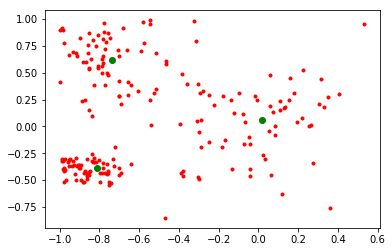

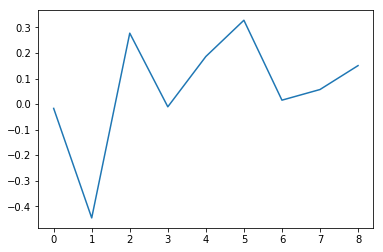

array([-0.01694371, -0.44589334,  0.2776184 , -0.01076238,  0.18625603,
        0.32824648,  0.01524765,  0.05693245,  0.15054282])

In [6]:
import numpy as np
import random
import matplotlib.pyplot as plt

########################################
# K-MEANS CLUSTERING AND GAP STATISTIC #
########################################

# Source: https://datasciencelab.wordpress.com/2013/12/12/clustering-with-k-means-in-python/
# Source: https://datasciencelab.wordpress.com/2013/12/27/finding-the-k-in-k-means-clustering/

NUM_REF_DATASETS = 10
REF_DATASET_SIZE = 100
MAX_K = 10

def init_board_gauss(N, k):
    n = float(N)/k
    X = []
    for i in range(k):
        c = (random.uniform(-1, 1), random.uniform(-1, 1))
        s = random.uniform(0.05,0.5)
        x = []
        while len(x) < n:
            a, b = np.array([np.random.normal(c[0], s), np.random.normal(c[1], s)])
            # Continue drawing points from the distribution in the range [-1,1]
            if abs(a) < 1 and abs(b) < 1:
                x.append([a,b])
        X.extend(x)
    X = np.array(X)[:N]
    return X

def cluster_points(X, mu):
    clusters  = {}
    for x in X:
        bestmukey = min([(i[0], np.linalg.norm(x-mu[i[0]])) \
                    for i in enumerate(mu)], key=lambda t:t[1])[0]
        try:
            clusters[bestmukey].append(x)
        except KeyError:
            clusters[bestmukey] = [x]
    return clusters
 
def reevaluate_centers(mu, clusters):
    newmu = []
    keys = sorted(clusters.keys())
    for k in keys:
        newmu.append(np.mean(clusters[k], axis = 0))
    return newmu
 
def has_converged(mu, oldmu):
    return (set([tuple(a) for a in mu]) == set([tuple(a) for a in oldmu]))
 
def find_centers(X, K):
    # Initialize to K random centers
    oldmu = random.sample(X.tolist(), K)
    mu = random.sample(X.tolist(), K)
    while not has_converged(mu, oldmu):
        oldmu = mu
        # Assign all points in X to clusters
        clusters = cluster_points(X, mu)
        # Reevaluate centers
        mu = reevaluate_centers(oldmu, clusters)
    return(mu, clusters)

def Wk(mu, clusters):
    K = len(mu)
    return sum([np.linalg.norm(mu[i]-c)**2/(2*len(c)) for i in range(K) for c in clusters[i]])

def bounding_box(X):
    xmin, xmax = min(X,key=lambda a:a[0])[0], max(X,key=lambda a:a[0])[0]
    ymin, ymax = min(X,key=lambda a:a[1])[1], max(X,key=lambda a:a[1])[1]
    return (xmin,xmax), (ymin,ymax)
 
def gap_statistic(X):
    (xmin,xmax), (ymin,ymax) = bounding_box(X)
    # Dispersion for real distribution
    ks = range(1,MAX_K+1)
    Wks = np.zeros(len(ks))
    Wkbs = np.zeros(len(ks))
    sk = np.zeros(len(ks))
    for indk, k in enumerate(ks):
        mu, clusters = find_centers(X,k)
        Wks[indk] = np.log(Wk(mu, clusters))
        # Create B reference datasets
        B = NUM_REF_DATASETS
        BWkbs = np.zeros(B)
        for i in range(B):
            Xb = []
            for n in range(REF_DATASET_SIZE):
                Xb.append([random.uniform(xmin,xmax),
                          random.uniform(ymin,ymax)])
            Xb = np.array(Xb)
            mu, clusters = find_centers(Xb,k)
            BWkbs[i] = np.log(Wk(mu, clusters))
        Wkbs[indk] = sum(BWkbs)/B
        sk[indk] = np.sqrt(sum((BWkbs-Wkbs[indk])**2)/B)
    sk = sk*np.sqrt(1+1/B)
    return(ks, Wks, Wkbs, sk)

points = init_board_gauss(200, 3)
centers = np.array(find_centers(points, 3)[0])
ks, logWks, logWkbs, sk = gap_statistic(points)
gap = logWkbs - logWks
gap_stat = gap[:MAX_K-1]-(gap[1:MAX_K]-sk[1:MAX_K])
plt.plot(points[:,0], points[:,1], 'r.')
plt.plot(centers[:,0], centers[:,1], 'go')
plt.show()
plt.plot(gap_stat)
plt.show()
gap_stat